<h1><center>Homework 3</center></h1>

<h3>Submission Instructions</h3>
<p>
For submission, you only need to submit your Jupyter Notebook file named "StudentName_ID.ipynb"

If you have any questions, you can contact me via kamard@itu.edu.tr
</p>

<h3> Homework Instructions </h3>

<p>In this homework, you will implement Girvan-Newman algorithm, and use the algorithm to decompose the network into a number of modules so that it has the highest modularity. Remember the steps of Girvan-Newman algorithm from Graph Theory Blink 9.3:

<ol>
  <li>Calculate the betweenness centrality of each edge in graph G</li>
  <li>Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.</li>
  <li>Recalculate the betweenness centrality of all remaining edges</li>
  <li>Repeat steps 2 and 3 until no edges remain. </li>
</ol>

You will need to modify the above steps so that you find the number of connected components that has the highest modularity. To do that, you can calculate modularity each time new connected component is formed during the Girvan-Newman algorithm, and find the decomposition with highest modularity. Don't forget to compute the modularity of the initial network, as network might not consist any modules 

<h2>WHAT YOU NEED TO DO</h2>
<ol>
    <li> Read and visualize the given graph adjacency matrix files. Give brief comments about the networks' hiearchy and modularity <b>(20p)</b>
    <li> Implement the Girvan-Newman algorithm: Write a function that uses Girvan-Newman algorithm to find the number of connected components that gives the highest modularity. In the same function or another function, return the new graph with the number of connected components you have found (basically, remove edges until the number of connected components are equal to the one you found with your algorithm). <b>(60p)</b>
    <li>Apply the function on the given networks. Visualize the final results. Assign different colors to each node in the visualization. <b>(10p)</b>
    <li> What conclusions can you derive about the networks after you run the algorithm on them and visualize the final result? Give brief comments. <b>(10p)</b>
    <li><b>BONUS</b> What are the key differences between Agglomerative Clustering and Divisive Clustering? Which one of these does the Girvan-Newman algorithm belong to? Explain.<b>(3p)</b> 

Below, I have given you some basic functions to start with. 
</p>

In [1]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt

You can use RandomGraph function to create a random graph that returns the graph as both networkx.Graph and adjacency matrix as numpy.array.

(Optional, will not affect your grade) You can modify the VisualiseGraph function to give each connected component different graph, or make other interesting visualizations. Play with it however you want!

In [2]:
def RandomAdjacencyMatrix(n = 10, p = 0.5):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n = 10, p = 0.5):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1])
    
    return G, M

def VisualizeGraph(G):
    nx.draw_networkx(G)
    plt.show()
    

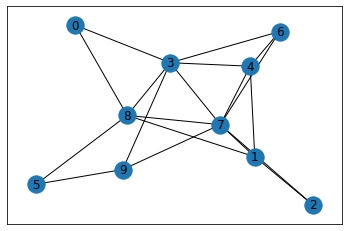

In [3]:
n = 10
p = 0.5
G, M = RandomGraph(n, p)
VisualizeGraph(G)

## You can start from here.

Implement all your codes and write all your comments below this cell. 

For the algorithm; you are only allowed to use networkx to compute <b>modularity, connected components and betwenness centralities.</b> You need to implement Girvan-Nerman and rest of the algorithm by yourself. 

### 1. Read and visualize the given graphs

In [4]:
def adjacencyMatrixToGraph(matrix):
    edges = np.transpose(np.where(matrix==1))
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1])
    return G

matrix1 = np.load('./NetworkData1.npy')
graph1 = adjacencyMatrixToGraph(matrix1)
matrix2 = np.load('./NetworkData2.npy')
graph2 = adjacencyMatrixToGraph(matrix2)
matrix3 = np.load('./NetworkData3.npy')
graph3 = adjacencyMatrixToGraph(matrix3)

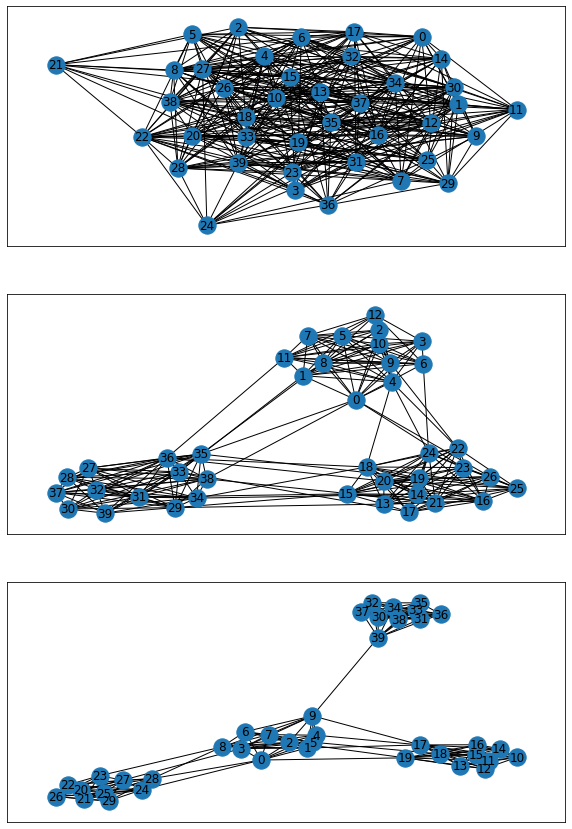

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 15))
nx.draw_networkx(graph1, ax=ax0)
nx.draw_networkx(graph2, ax=ax1)
nx.draw_networkx(graph3, ax=ax2)
plt.show()

From the previous visualisation, it appears that the first network is a homogeneously organized network, where each nodes and edges seems to have the same effect on the global network.

The second network is organized into three modules, that is three groups of nodes highly intraconnected, lightly interconnected with each others, from 5 to 10 connections between modules, while each modules hold more than 10 nodes.

The third network seems to have a hierarchical architecture. In fact, there seems to be four different modules, but only one of them connect all the others together, serving as a core module.

### 2. Implement the Girvan-Newman algorithm

In [6]:
def GirvanNewmanAlgorithm(graph):
    connComps = graph.copy()
    components = [*nx.connected_components(connComps)]
    maxMod = nx_comm.modularity(graph, components)

    G = graph.copy()
    while len(G.edges) > 0:
        centralities = nx.edge_betweenness_centrality(G)
        maxCentrality = max(centralities.values())
        # List all edges with the highest betweenness centrality
        edges = [edge for edge, centrality in centralities.items() if centrality == maxCentrality]

        if len(edges) > 1:
            G.remove_edge(*edges[np.random.randint(len(edges))])
        else:
            G.remove_edge(*edges[0])

        newComponents = [*nx.connected_components(G)]
        # Only calculate the modularity when there are different numbers of connected components
        if len(newComponents) != len(components):
            modularity = nx_comm.modularity(graph, newComponents)
            if modularity > maxMod:
                connComps = G.copy()
                components = newComponents
                maxMod = modularity

    return connComps

### 3. Visualize the networks after applying the Girvan-Newman algorithm

In [7]:
def displayModularizedGraph(graph, axs):
    def indexToColor(i, maxI):
        # Map i to a number between [0,3] and associate to a RGB color as follow:
        #   R = 1 (i ∈ [0,1]), 0 (i ∈ [1.5,2.5])
        #   G = 1 (i ∈ [1,2]), 0 (i ∈ [0,0.5]∪[2.5,3])
        #   B = 1 (i ∈ [2,3]), 0 (i ∈ [0.5,1.5])
        value = (i+0.5) / maxI * 3
        # Add a random value to each component RGB
        randv = [(v*2-1) / (maxI*0.8) for v in np.random.rand(3)]

        r = max(0, min(1, 2 - 2*abs(((value+1.5)%3-1.5) - 0.5) + randv[0])) # Re-bound v to [-1.5,1.5]
        g = max(0, min(1, 2 - 2*abs(value               - 1.5) + randv[1]))
        b = max(0, min(1, 2 - 2*abs(((value+1.5)%3+1.5) - 2.5) + randv[2])) # Re-bound v to [1.5,4.5]
        return (r,g,b)

    sparsedGraph = GirvanNewmanAlgorithm(graph)
    components = [*nx.connected_components(sparsedGraph)]
    nComp = len(components)
    # Assign the component's color to each node
    colors = {
            node: indexToColor(iComp, nComp)
        for iComp,comp in enumerate(components)
        for node in comp
    }
    nx.draw_networkx(graph,        ax=axs[0], nodelist=list(colors.keys()), node_color=list(colors.values()))
    nx.draw_networkx(sparsedGraph, ax=axs[1], nodelist=list(colors.keys()), node_color=list(colors.values()))

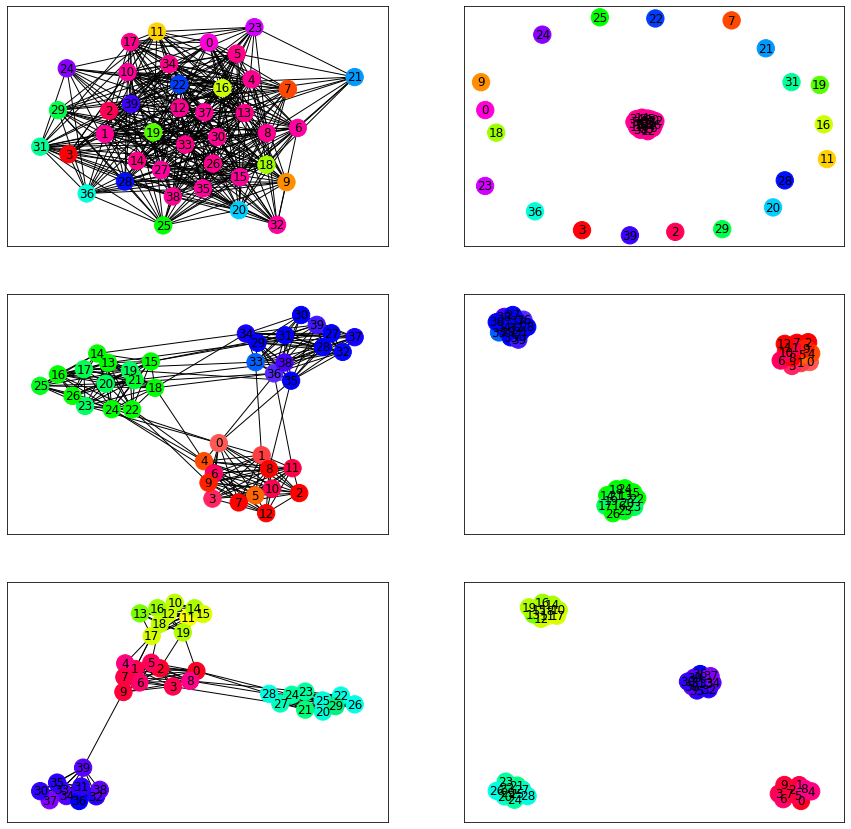

In [9]:
fig, (axs0, axs1, axs2) = plt.subplots(3, 2, figsize=(15, 15))
displayModularizedGraph(graph1, axs0)
displayModularizedGraph(graph2, axs1)
displayModularizedGraph(graph3, axs2)
plt.show()

### 4. Conclude

After isolating the connected components that give the highest modularity, we observe different things than before.

The first network, which appeared to be an homogeneous network is now divided into a main module and several isolated nodes.

The second and third networks, on the other hand, are actually decomposed as previously expected. Moreover, once divided into modules, it is easier the spot the highest hierarchie of the third network, as we can more easily notice that the edges between modules are all connected to the central module.

### *BONUS*. Agglomerative Clustering vs. Divisive Clustering. Which one is the Girvan-Newman algorithm.

Agglomerative clustering consist to create new clusters by combining several pre-existing clusters with some similarities. The initial clusters in such a case consist of a single node.

Divisive clustering, on the other hand, create new clusters by dividing original clusters according to some differences. The original one is this case consists of the entire network.

Considering the Girvan-Newman algorithm, and following the previous definitions, it appears to be part of the divisive clustering category. Indeed, the Girvan-Newman algorithm initially use the whole network, and divides it into sub-clusters.